In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# this path needs to be appended to run the code! This initializes the environment
import sys
sys.path.append('/content/drive/My Drive/DeepLearning Optimization/Code_for_report/NYC_maze/custom_gym/Nyc_maze/custom_env_dir/envs')

In [3]:
import os
wd = os.getcwd()
print(wd)
os.chdir("/content/drive/My Drive/DeepLearning Optimization")
print(os.getcwd())

/content
/content/drive/My Drive/DeepLearning Optimization


In [0]:
import gym
from gym import spaces
import matplotlib.pyplot as plt
from abc import ABC
from abc import abstractmethod
#from gym_pull.envs.registration import registry, register, make, spec
import numpy as np
from gym.utils import seeding
from PIL import Image
from skimage.draw import rectangle
import pandas as pd
from collections import namedtuple
from custom_env import NycMaze1
import sys
from contextlib import closing
from six import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np
from IPython.display import clear_output
from IPython.display import display
from time import sleep
import matplotlib.image as image
from gym import Env, spaces
from gym.utils import seeding
from matplotlib import animation

In [0]:
#Actions = {'North': 0, 'South': 1, 'East': 2, 'West': 3}

In [0]:
class environment(Env):
  def __init__(self, nS, nA, P, isd, start_state):
    # nS = number of States
    # na = Number of actions
    # P = transitions 
    # isd = initial state distribution 
    self.start_state = start_state
    self.s = start_state 
    self.P = P
    self.isd = isd
    self.lastaction = None
    self.nS = nS
    self.nA = nA

    self.action_space = spaces.Discrete(self.nA)
    self.observation_space = spaces.Discrete(self.nS)
    self.seed()

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def reset(self):
    raise NotImplementedError

  def step(self, a):
    raise NotImplementedError


## This is our environment class of our nyc maze
A state with two zeros at the end is when traffic is not present, a state with the values of the state copied at the end (2323) is when traffic is present

In [0]:
class driver(environment):
  def __init__(self, **kwargs):
    self.start = np.array([2,2])
    self.maze = None

    self.start = kwargs['start_car']
    self.goal = kwargs['destination']
    self.width = kwargs['block_width']
    self.height = kwargs['block_height']
    self.blocks = kwargs['blocks']
    self.obstacle_width = kwargs['obstacle_width']
    self.obstacle_height = kwargs['obstacle_height']
    self.traffic_reward = kwargs['traffic_reward']
    self.traffics = kwargs['traffics'] #traffic states that are possible can be changed
    self.maze = self.build_maze(self.width,self.height, self.obstacle_width, self.obstacle_height, self.blocks)
    self.set_start(self.start)
    self.state = self.encode_state(self.start[0], self.start[1], 0, 0) #just as a start definition no traffic present 
    self.set_goal(self.goal)
    self.trafic_R = None
    self.trafic_ON = False
    num_states = self.width*self.height*self.width*self.height #needs to be size 10*10*10*10 because that many states available
    num_actions = 4 #"(N,S,E,W)"
    self.observation_space = num_states
    self.action_space = num_actions
    
    num_rows = self.width
    num_col = self.height
    traf_rows = self.width
    traf_cols = self.height
    max_rows = num_rows - 1
    max_col = num_col - 1

    self.R = {state: {action: [] for action in range(num_actions)} for state in range(num_states+1)}

    initial_state_distribution = np.zeros(num_states)
    
    for row in range(num_rows):
      for col in range(num_col):
        for traf_row in range(traf_rows):
          for traf_col in range(traf_cols):
            state = self.encode_state(row,col,traf_row,traf_col)
            if (row,col) != self.goal:
              initial_state_distribution[state] += 1
            for action in range(num_actions):
              new_row, new_col = row, col 
              new_traf_row, new_traf_col = traf_row, traf_col
              done = False
              reward = -1
              car_loc = (row,col)
              if traf_row !=0 and traf_col != 0: #then not in trafic
                #Actions = {'North': 0, 'South': 1, 'East': 2, 'West': 3}
                if action == 0:
                  new_row = max(row - 1, 0)
                  new_traf_row = new_row
                elif action == 1:
                  new_row = min(row + 1, max_rows)
                  new_traf_row = new_row
                elif action == 2:
                  new_col = min(col + 1, max_col)
                  new_traf_col = new_col
                elif action == 3:
                  new_col = max(col - 1, 0)
                  new_traf_col = new_col

                if (new_row,new_col) == (self.goal[0], self.goal[1]):
                  done = True
                  reward = 100 # reached the destination 🏁
                elif self.maze[new_row, new_col] == 1:
                  reward = -200 # this is a crash 🚒🚑
                if self.encode_coord(new_traf_row, new_traf_col) in self.traffics: #if the next state is in predefined state where traffic is then reward set 
                #to predefinded reward
                  reward = self.traffic_reward

                new_state = self.encode_state(new_row,new_col,new_traf_row,new_traf_col)
                self.R[state][action].append(1)
                self.R[state][action].append(new_state)
                self.R[state][action].append(reward)
                self.R[state][action].append(done)
              
              else:
                #Actions = {'North': 0, 'South': 1, 'East': 2, 'West': 3}
                if action == 0:
                  new_row = max(row - 1, 0)
                elif action == 1:
                  new_row = min(row + 1, max_rows)
                elif action == 2:
                  new_col = min(col + 1, max_col)
                elif action == 3:
                  new_col = max(col - 1, 0)

                if (new_row,new_col) == (self.goal[0], self.goal[1]):
                  done = True
                  reward = 100 # reached the destination 🏁
                elif self.maze[new_row, new_col] == 1:
                  reward = -200 # this is a crash 🚒🚑
                
                new_state = self.encode_state(new_row,new_col,0,0)
                self.R[state][action].append(1)
                self.R[state][action].append(new_state)
                self.R[state][action].append(reward)
                self.R[state][action].append(done)
    
    initial_state_distribution /= initial_state_distribution.sum()
    environment.__init__(self, num_states, num_actions, self.R, initial_state_distribution, self.start) 

  def build_maze(self,width, height, obstacle_width, obstacle_height, blocks):
    x = np.ones([height, width], dtype=np.uint8)
    start = (2,2)
    end = (height-3,width -3)
    rr, cc = rectangle(start, end, shape = x.shape)
    x[rr, cc] = 1
    #print(width // blocks)
    for i in range(0,width-1,(width//blocks)):
      x[:,i] = 0
    for i in range(0,height-1,(height//blocks)):
      x[i,:] = 0
    x[1, :] = 0
    x[-2, :] = 0
    x[:, 1] = 0
    x[:, -2] = 0
    #builds the walls
    x[0, :] = 1
    x[-1, :] = 1
    x[:, 0] = 1
    x[:, -1] = 1
    return x

  def encode_coord(self,row, column):
    i = row
    i *= self.height
    i += column
    return i 

  def encode_state(self,row, column, row_traffic, column_traffic):
    i = row
    i *= self.height
    i += column
    i *= self.width
    i += row_traffic
    i *= self.height
    i += column_traffic
    return i 

  def decode_state(self, state):
    # out = [row,column]
    out = []
    out.append(state % self.width)
    state = state // self.width
    out.append(state % self.height)
    state = state // self.height
    out.append(state % self.width)
    state = state // self.width
    out.append(state % self.height)
    return tuple(reversed(out))

  def decode_coord(self, coord):
    # out = [row,column]
    out = []
    out.append(coord % self.width)
    coord = coord // self.width
    out.append(coord % self.height)
    return tuple(reversed(out))

  def set_start(self, start):
    self.maze[start[0],start[1]] = 10
    self.start = start
    self.state = self.encode_state(start[0], start[1], start[2], start[3])

  def set_goal(self,goal):
    self.maze[goal] = 12
    self.goal = (goal[0], goal[1],0,0)

  def reset(self):
    self.state = self.encode_state(self.start[0], self.start[1],0,0)
    return self.state

  def step(self, a):
    x,y = self.decode_state(self.state)[0], self.decode_state(self.state)[1]
    if self.trafic_ON:
      env.state = self.encode_state(x,y,x,y)
    if self.trafic_ON is False:
      env.state = self.encode_state(x,y,0,0)
    transitions = self.R[self.state][a]
    prob, state, reward, done = transitions[0], transitions[1], transitions[2], transitions[3]
    return prob, state, reward, done

  def render(self, states = []):
    out = self.maze.copy()
    out[np.where(out == 0)] = 2
    out[np.where(out == 1)] = 4
    if self.trafic_ON:
      for i in range(len(self.traffics)):
        out[self.decode_coord(traffics[i])] = 9
    for i in range(len(states)):
      (x,y,_,_) = self.decode_state(states[i])
      out[x,y] = 5
    #print("decoding state: ", self.state)
    car_row, car_col,_,_ = self.decode_state(self.state)
    #print("car_row: ", car_row, "car_col: ", car_col)
    out[car_row][car_col] = 7
    img = out
    return img

In [8]:
# size of the grid
block_width = 10 
block_height = 10
blocks = 3
start_car = ((block_height-2),1,0,0)
destination = (1, block_width-2)
#where possible traffic jams can occur
traffics = [61, 62, 63, 64, 65, 66, 67, 23, 26, 28] 

environment_params = {'block_width': block_width, 'block_height': block_height, 'blocks' : blocks, 'obstacle_width': block_width - 2, 'obstacle_height': 3, 'start_car': start_car, 'destination': destination, 'traffic_reward': -15, 'traffics':traffics}
env = driver(**environment_params)
print("start:",env.start,"destination:",env.goal)
print(env.maze)
print("Action Space '{}'".format(env.action_space))
print("State Space '{}'".format(env.observation_space))


start: (8, 1, 0, 0) destination: (1, 8, 0, 0)
[[ 1  1  1  1  1  1  1  1  1  1]
 [ 1  0  0  0  0  0  0  0 12  1]
 [ 1  0  1  0  1  1  0  1  0  1]
 [ 1  0  0  0  0  0  0  0  0  1]
 [ 1  0  1  0  1  1  0  1  0  1]
 [ 1  0  1  0  1  1  0  1  0  1]
 [ 1  0  0  0  0  0  0  0  0  1]
 [ 1  0  1  0  1  1  0  1  0  1]
 [ 1 10  0  0  0  0  0  0  0  1]
 [ 1  1  1  1  1  1  1  1  1  1]]
Action Space 'Discrete(4)'
State Space 'Discrete(10000)'


state 8100


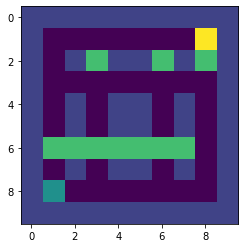

In [9]:
print("state", env.state)
env.trafic_ON = True
img = env.render()
plt.imshow(img, cmap= 'viridis')

state: 8100

 setting state to state next to goal
state: 2800

 setting state to state at intersection
state: 3300

 setting state to state at intersection with traffic true
state: 3333

 setting state to state when crashed
state: 2900

 reset environment state: 8100

These are the transition values of the mentioned states
 [{0: [1, 1800, 100, True], 1: [1, 3800, -1, False], 2: [1, 2900, -200, False], 3: [1, 2700, -200, False]}
 {0: [1, 2300, -1, False], 1: [1, 4300, -1, False], 2: [1, 3400, -1, False], 3: [1, 3200, -1, False]}
 {0: [1, 2323, -15, False], 1: [1, 4343, -1, False], 2: [1, 3434, -1, False], 3: [1, 3232, -1, False]}
 {0: [1, 1900, -200, False], 1: [1, 3900, -200, False], 2: [1, 2900, -200, False], 3: [1, 2800, -1, False]}
 {0: [1, 7100, -1, False], 1: [1, 9100, -200, False], 2: [1, 8200, -1, False], 3: [1, 8000, -200, False]}]


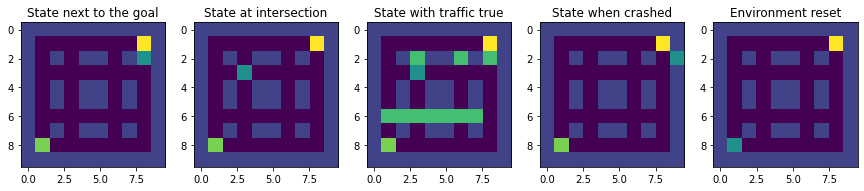

In [10]:
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)

fig, axs = plt.subplots(1,5, figsize = (15,15))
transitions_val = []

env.trafic_ON = False
#we set a state where we are next to the goal
print("\n setting state to state next to goal")
state = (destination[0] + 1, destination[1])
state = env.encode_state(state[0],state[1],0,0)
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)

#print("destination:",env.goal)
#print(env.R[env.state])
transitions_val.append(env.R[env.state])
#print("transitions: ", env.R[env.state][1])
img = env.render()
axs[0].imshow(img)
axs[0].set_title("State next to the goal")

#we set a state at a intersection to check 
print("\n setting state to state at intersection")
intersect = block_width / blocks
intersect = int(intersect)
state = env.encode_state(intersect,intersect,0,0)
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)
transitions_val.append(env.R[env.state])
#print("destination:",env.goal)
#print(env.R[36])
img = env.render()
axs[1].imshow(img)
axs[1].set_title("State at intersection")

#we set a state at a intersection with traffic true
print("\n setting state to state at intersection with traffic true")
env.trafic_ON = True
intersect = block_width / blocks
intersect = int(intersect)
state = env.encode_state(intersect,intersect,intersect,intersect)
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)
transitions_val.append(env.R[env.state])
#print("destination:",env.goal)
#print(env.R[36])
img = env.render()
axs[2].imshow(img)
axs[2].set_title("State with traffic true")
env.trafic_ON = False

#we set a state where we are chrashed in a building only acceptable action is getting out of the wall (West in this case)
#print("\n setting car crash, nooo")
print("\n setting state to state when crashed")
state = env.encode_state(2,9,0,0)
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)
#print("destination:",env.goal)
#print(env.R[29])
transitions_val.append(env.R[env.state])
img = env.render()
axs[3].imshow(img)
axs[3].set_title("State when crashed")

print("\n reset environment state:",env.reset())
#print("state: ", env.state)
img = env.render()
transitions_val.append(env.R[env.state])
axs[4].imshow(img)
axs[4].set_title("Environment reset")


print("\nThese are the transition values of the mentioned states\n",np.asarray(transitions_val))

In [11]:
# a small test of the transition values of environment 
env.trafic_ON = True
env.state = env.encode_state(3,3,0,0)
print("env.state:",env.state,", env.Trafic_ON = ",env.trafic_ON)
action = 0
Prob, Next_state, Reward, Done = env.step(action)
print("Prob:", Prob,"Next_state:", Next_state,"reward:", Reward,"Done:", Done)

env.state: 3300 , env.Trafic_ON =  True
Prob: 1 Next_state: 2323 reward: -15 Done: False


## Here we start training
When traffic is True then the agent will be in state 2323 when traffic is False then the agent will state 2300. The agent can only receive a penalty of -15 from traffic if the agent is in a tarffic state. During training the traffic is on for random values, similar to epsilon greedy strategy. In this case we are training with epsilon decay. 


In [12]:
# ================================== TRAINING ==================================
import time
start_time = time.time()
from IPython.display import clear_output
import random
import pandas as pd

print( 20 * "#" + " Attention resetting Q matrix " + 20 * "#")
Q = np.zeros([env.observation_space.n, env.action_space.n])
print("Q matrix shape\n",Q.shape)
# ============================= Training parameters ============================
alpha = 0.1
gamma = 0.6
epsilon = 1  
min_epsilon = 0.05 
epsilon_decay = 5e-5 
# random amount of times during training where traffic is true
threshold_traffic = 0.8

# ============================= start of Training ==============================
epochs = []
average_rewards = []
steps = []
steps_until_goal = []
reward_until_goal_list = []
stop = False
print("start state: ", env.start, "destination: ", env.goal)
start_Q = np.zeros((2,4))
# we need to train for a long time to ensure the agent 
# learns with and without traffic
for i in range(1,50_000): 
  state = env.reset()
  epochs, reward = 0,0
  step_until_goal = 0
  total_reward = 0
  reward_until_goal = 0
  done = False
  steps_traffic = 0
  steps_no_traffic = 0 
  while not done:
    # ============================= Traffic on or off ==========================
    if random.uniform(0,1) > threshold_traffic: #make traffic true or false
      env.trafic_ON = True
      steps_traffic += 1
    else:
      env.trafic_ON = False
      steps_no_traffic += 1
    # ============================= Encode the state ==========================
    x,y = env.decode_state(env.state)[0], env.decode_state(env.state)[1]
    if env.trafic_ON:
      env.state = env.encode_state(x,y,x,y)
    if env.trafic_ON is False:
      env.state = env.encode_state(x,y,0,0)
    
    # ============================== Epsilon greedy ============================
    state = env.state
    if random.uniform(0,1) < epsilon: 
      action = env.action_space.sample() # explore 🧐
    else:
      action = np.argmax(Q[state]) # exploit 😈

    # =============================== Take a step ==============================
    Prob, Next_state, Reward, Done = env.step(action)
    old_value = Q[state,action]
    next_max = np.max(Q[Next_state])
    old_state = state
    new_value = (1 - alpha)*old_value + alpha*(Reward + gamma + next_max)
    Q[state, action] = new_value
    
    # ====================== keeping track of metrics ==========================
    total_reward += Reward
    reward_until_goal += Reward
    state = Next_state
    env.state = state
    epochs += 1
    done = Done
    step_until_goal += 1
    if done:
      steps_until_goal.append(step_until_goal)
      reward_until_goal_list.append(reward_until_goal)

  
  # ================================ Epsilon decay =============================
  epsilon = max(min_epsilon, (epsilon*(1-epsilon_decay)))

  if i % 2000 == 0:
    print("Reward until destination: ", total_reward/epochs, "***steps until goal", step_until_goal)
    print("We have taken action '{}' and this resulted in state '{}' with a reward '{}'".format(action, Next_state, Reward))
    print("During this training '{}' of steps were with traffic and '{}' of steps were without traffic".format(steps_traffic, steps_no_traffic))
    average_rewards.append(total_reward/epochs)
    steps.append(step_until_goal)
  if i % 10000 == 0:
    print(20 * "#" + " We are training with Q learning  " + 20 * "#")

# ====================== saving of the metrics =================================
steps_until_goal = np.array(steps_until_goal, dtype = 'float')
reward_until_goal = np.array(reward_until_goal_list)
df = pd.DataFrame(steps_until_goal, columns = ['Steps until goal'] )
df['Reward_until_goal'] = reward_until_goal
df.to_csv("scores_during_training.csv")
print(10* "=" + "we saved the metrics" + 10* "=")
print(20 * "#" + " We Finished training with Q learning " + 20 * "#")
print(f'the final epsilon value after training is {epsilon}')


#################### Attention resetting Q matrix ####################
Q matrix shape
 (10000, 4)
start state:  (8, 1, 0, 0) destination:  (1, 8, 0, 0)
Reward until destination:  -92.62542955326461 ***steps until goal 291
We have taken action '2' and this resulted in state '1800' with a reward '100'
During this training '52' of steps were with traffic and '239' of steps were without traffic
Reward until destination:  -85.34482758620689 ***steps until goal 290
We have taken action '2' and this resulted in state '1800' with a reward '100'
During this training '54' of steps were with traffic and '236' of steps were without traffic
Reward until destination:  -67.87116564417178 ***steps until goal 163
We have taken action '2' and this resulted in state '1818' with a reward '100'
During this training '39' of steps were with traffic and '124' of steps were without traffic
Reward until destination:  -29.958333333333332 ***steps until goal 24
We have taken action '2' and this resulted in state 

# Let's plot the metrics of training

Steps until goal      22.0
Reward_until_goal   -120.0
Name: 49998, dtype: float64


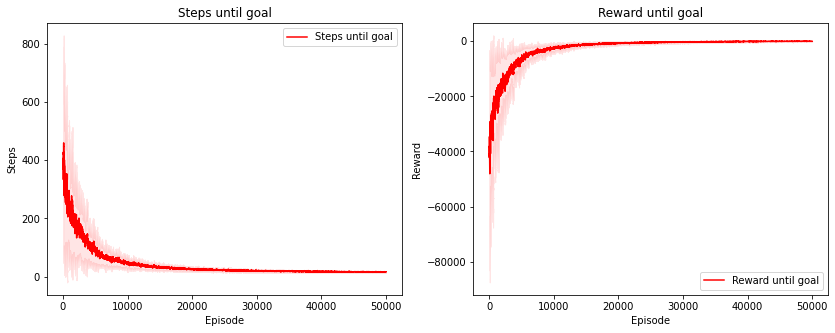

In [13]:
x = np.arange(0,len(df), 1)
fig, ax = plt.subplots(1,2, figsize =(14,5))
print(df.iloc[-1])
window = 50
std_steps = df['Steps until goal'].rolling(window).std()
ax[0].plot(x, df['Steps until goal'].rolling(window).mean(), label = 'Steps until goal', color = 'red')
ax[0].fill_between(range(len(df['Steps until goal'])), df['Steps until goal'].rolling(window).mean() - std_steps, df['Steps until goal'].rolling(window).mean() + std_steps, color = 'red', alpha = 0.1)
ax[0].set_title("Steps until goal")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Steps")
ax[0].legend(loc = 'upper right')
std_reward = df['Reward_until_goal'].rolling(window).std()
ax[1].plot(x, df['Reward_until_goal'].rolling(window).mean(), label = 'Reward until goal', color = 'red')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df['Reward_until_goal'].rolling(window).mean() - std_reward, df['Reward_until_goal'].rolling(window).mean() + std_reward, color = 'red', alpha = 0.1)
ax[1].set_title("Reward until goal")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")
ax[1].legend(loc = 'lower right')
plt.show()

## Let's evaluate the smart agent


In [22]:
# === Agent's performance after Q-learning with traffic off between 2 and 7====
total_epochs, total_penalties = 0, 0
episodes = 1
frames = []
states_eval = []
for _ in range(episodes):
  state = env.reset()
  epochs, step, reward = 0, 0, 0
  reward_until_goal = 0
  done = False
  while not done:
    # ============================= Traffic on or off ======================
    if step > 2 and step < 7:
      env.trafic_ON = False
    elif step > 11:
      env.trafic_ON = False
    else:
      env.trafic_ON = True
    # ============================= Encode the state =======================
    x,y = env.decode_state(env.state)[0], env.decode_state(env.state)[1]
    if env.trafic_ON:
      env.state = env.encode_state(x,y,x,y)
    if env.trafic_ON is False:
      env.state = env.encode_state(x,y,0,0)
    state = env.state
    print("step", step, "env traffic", env.trafic_ON, "state", state)
    step += 1
    action = np.argmax(Q[state])
    # ======================== Keeping track of metrics ====================
    Prob, Next_state, Reward, Done = env.step(action)
    state = Next_state
    states_eval.append(state)
    env.state = Next_state
    done = Done
    epochs += 1
    reward += Reward
    frames.append({'frame': env.render(states_eval), 'state': state, 'action': action, 'reward': reward})
  reward_until_goal += (reward/epochs)
  print("reached goal")
  total_epochs += epochs

print("average reward until goal: ", reward_until_goal/episodes)
print(f"Average timesteps per episode: {total_epochs / episodes}")

step 0 env traffic True state 8181
step 1 env traffic True state 8282
step 2 env traffic True state 8383
step 3 env traffic False state 8400
step 4 env traffic False state 8500
step 5 env traffic False state 8600
step 6 env traffic False state 7600
step 7 env traffic True state 6666
step 8 env traffic True state 5656
step 9 env traffic True state 4646
step 10 env traffic True state 3636
step 11 env traffic True state 3535
step 12 env traffic False state 3400
step 13 env traffic False state 3500
step 14 env traffic False state 3600
step 15 env traffic False state 2600
step 16 env traffic False state 1600
step 17 env traffic False state 1700
reached goal
average reward until goal:  4.611111111111111
Average timesteps per episode: 18.0


In [0]:
def create_animation(frames):
    fig = plt.figure()
    plt.axis("off")
    im = plt.imshow(frames[0], animated=True)

    def updatefig(i):
        im.set_array(frames[i])
        return im,
    ani = animation.FuncAnimation(fig, updatefig, frames=len(frames), interval=150, blit=True)
    plt.close()
    return ani

In [0]:
from IPython.display import HTML
def print_frames(frames):
  imgs = []
  steps = 0
  for i, frame in enumerate(frames):
    imgs.append(frame['frame'])
    steps += 1
    if (env.decode_state(frame['state'])[0],env.decode_state(frame['state'])[1]) == (env.goal[0], env.goal[1]):
      print("we reached our goal")
      print(f"State: {frame['state']}")
      print(f"Action: {frame['action']}")
      print(f"Reward: {frame['reward']}")
      print(f"With: {steps} steps")
      plt.imshow(frame['frame'])
      plt.axis('off')
      plt.show()
      sleep(1)

  return imgs

we reached our goal
State: 1800
Action: 2
Reward: 83
With: 18 steps


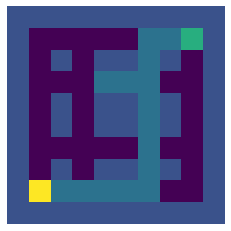

In [25]:
imgs = print_frames(frames)

In [26]:
ani = create_animation(imgs)
HTML(ani.to_html5_video())

In [0]:
ani.save('/content/drive/My Drive/DeepLearning Optimization/Code_for_report/NYC_maze/Animation_simple1.gif', writer=animation.PillowWriter(fps=1.8))

In [0]:
ani.save('/content/drive/My Drive/DeepLearning Optimization/Code_for_report/NYC_maze/Animation1.mp4', writer='ffmpeg', fps=2, dpi=100, metadata={'title':'test'})

In [0]:
# Agent's performance after Q-learning with traffic off between 2 and 7 and off after 11 
total_epochs, total_penalties = 0, 0
episodes = 1
frames = []
states_eval = []
for _ in range(episodes):
  state = env.reset()
  epochs, step, reward = 0, 0, 0
  reward_until_goal = 0
  done = False
  while not done:
    # ============================= Traffic on or off ======================
    if step > 3 and step < 7:
      env.trafic_ON = False
    elif step > 11:
      env.trafic_ON = False
    else:
      env.trafic_ON = True
    # ============================= Encode the state =======================
    x,y = env.decode_state(env.state)[0], env.decode_state(env.state)[1]
    if env.trafic_ON:
      env.state = env.encode_state(x,y,x,y)
    if env.trafic_ON is False:
      env.state = env.encode_state(x,y,0,0)
    state = env.state
    print("step", step, "env traffic", env.trafic_ON, "state", state)
    step += 1
    action = np.argmax(Q[state])
    # ======================== Keeping track of metrics ====================
    Prob, Next_state, Reward, Done = env.step(action)
    state = Next_state
    states_eval.append(state)
    env.state = Next_state
    done = Done
    epochs += 1
    reward += Reward
    frames.append({'frame': env.render(states_eval), 'state': state, 'action': action, 'reward': reward})
  reward_until_goal += (reward/epochs)
  print("reached goal")
  total_epochs += epochs

print("average reward until goal: ", reward_until_goal/episodes)
print(f"Average timesteps per episode: {total_epochs / episodes}")

step 0 env traffic True state 8181
step 1 env traffic True state 8282
step 2 env traffic True state 8383
step 3 env traffic True state 8484
step 4 env traffic False state 8500
step 5 env traffic False state 8600
step 6 env traffic False state 7600
step 7 env traffic True state 6666
step 8 env traffic True state 5656
step 9 env traffic True state 4646
step 10 env traffic True state 3636
step 11 env traffic True state 3535
step 12 env traffic False state 3400
step 13 env traffic False state 3500
step 14 env traffic False state 3600
step 15 env traffic False state 2600
step 16 env traffic False state 1600
step 17 env traffic False state 1700
reached goal
average reward until goal:  4.611111111111111
Average timesteps per episode: 18.0


we reached our goal
State: 1800
Action: 2
Reward: 83
With: 18 steps


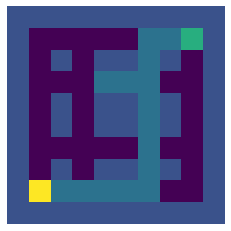

In [0]:
imgs = print_frames(frames)

In [0]:
ani = create_animation(imgs)
HTML(ani.to_html5_video())

In [0]:
ani.save('/content/drive/My Drive/DeepLearning Optimization/Code_for_report/NYC_maze/Animation2.mp4', writer='ffmpeg', fps=2, dpi=100, metadata={'title':'test'})

## Let's try parameter tuning


In [0]:
############### training #############
import time
start_time = time.time()
from IPython.display import clear_output
import random
import pandas as pd
import math

print( 20 * "#" + " Attention resetting Q matrix " + 20 * "#")
Q = np.zeros([env.observation_space.n, env.action_space.n])
print("Q matrix shape\n",Q.shape)

alpha = 0.1
gamma = 0.2

while gamma <= 1:
  ##### epsilon values ####
  epsilon = 0.7  ############
  min_epsilon = 0.05 #######
  epsilon_decay = 1e-5 ####
  #########################
  # random amount of times during training where traffic is true
  threshold_traffic = 0.8
  ########################
  epochs = []
  average_rewards = []
  steps = []
  steps_until_goal = []
  reward_until_goal_list = []
  stop = False
  print("start state: ", env.start, "destination: ", env.goal)
  start_Q = np.zeros((2,4))
  for i in range(1,50_000): #We need to train very long to make sure we train for traffic and without traffic
    state = env.reset()
    #print("state", state)
    epochs, reward = 0,0
    step_until_goal = 0
    total_reward = 0
    reward_until_goal = 0
    done = False
    steps_traffic = 0
    steps_no_traffic = 0 
    while not done:
      ###### traffic on or off ########
      if random.uniform(0,1) > threshold_traffic: #make traffic true or false
        env.trafic_ON = True
        steps_traffic += 1
      else:
        env.trafic_ON = False
        steps_no_traffic += 1
      
      x,y = env.decode_state(env.state)[0], env.decode_state(env.state)[1]
      if env.trafic_ON:
        env.state = env.encode_state(x,y,x,y)
      if env.trafic_ON is False:
        env.state = env.encode_state(x,y,0,0)
      
      ######## epsilon greedy
      state = env.state
      if random.uniform(0,1) < epsilon: 
        action = env.action_space.sample() # explore 🧐
      else:
        action = np.argmax(Q[state]) # exploit 😈

      Prob, Next_state, Reward, Done = env.step(action)
      old_value = Q[state,action]
      next_max = np.max(Q[Next_state])
      old_state = state
      new_value = (1 - alpha)*old_value + alpha*(Reward + gamma + next_max)
      Q[state, action] = new_value
      
      ### metrics ####
      total_reward += Reward
      reward_until_goal += Reward
      state = Next_state
      env.state = state
      epochs += 1
      done = Done
      step_until_goal += 1

      
      #### append metrics to list ###
      if done:
        steps_until_goal.append(step_until_goal)
        reward_until_goal_list.append(reward_until_goal)

    
    ##### epsilon decay
    epsilon = max(min_epsilon, (epsilon*(1-epsilon_decay)))

    if i % 10000 == 0:
      print("Reward until destination: ", total_reward/epochs, "***steps until goal", step_until_goal)
      print("We have taken action '{}' and this resulted in state '{}' with a reward '{}'".format(action, Next_state, Reward))
      print("During this training '{}' of steps were with traffic and '{}' of steps were without traffic".format(steps_traffic, steps_no_traffic))
      average_rewards.append(total_reward/epochs)
      steps.append(step_until_goal)
    if i % 40000 == 0:
      print(20 * "#" + " We are training with Q learning  " + 20 * "#")

  steps_until_goal = np.array(steps_until_goal, dtype = 'float')
  reward_until_goal = np.array(reward_until_goal_list)
  print(steps_until_goal.shape)
  print(steps_until_goal)
  df = pd.DataFrame(steps_until_goal, columns = ['Steps until goal'] )
  df['Reward_until_goal'] = reward_until_goal
  df.to_csv("scores_training_gamma_0_" + str(int(gamma*10)) +"_.csv")
  print(10* "=" + "we saved the metrics" + 10* "=")
  print(20 * "#" + " We Finished training with Q learning " + 20 * "#")
  print(f'the final epsilon value after training is {epsilon}')
  print(f'trained with gamma{gamma}')
  gamma += 0.2
  gamma = round(gamma, 1)

#################### Attention resetting Q matrix ####################
Q matrix shape
 (10000, 4)
start state:  (8, 1, 0, 0) destination:  (1, 8, 0, 0)
Reward until destination:  -27.113636363636363 ***steps until goal 44
We have taken action '0' and this resulted in state '1800' with a reward '100'
During this training '12' of steps were with traffic and '32' of steps were without traffic
Reward until destination:  -38.36666666666667 ***steps until goal 30
We have taken action '0' and this resulted in state '1800' with a reward '100'
During this training '7' of steps were with traffic and '23' of steps were without traffic
Reward until destination:  -16.63157894736842 ***steps until goal 19
We have taken action '2' and this resulted in state '1818' with a reward '100'
During this training '2' of steps were with traffic and '17' of steps were without traffic
Reward until destination:  -40.035714285714285 ***steps until goal 28
We have taken action '2' and this resulted in state '1800' 

Unnamed: 0           49998.0
Steps until goal        28.0
Reward_until_goal     -524.0
Name: 49998, dtype: float64


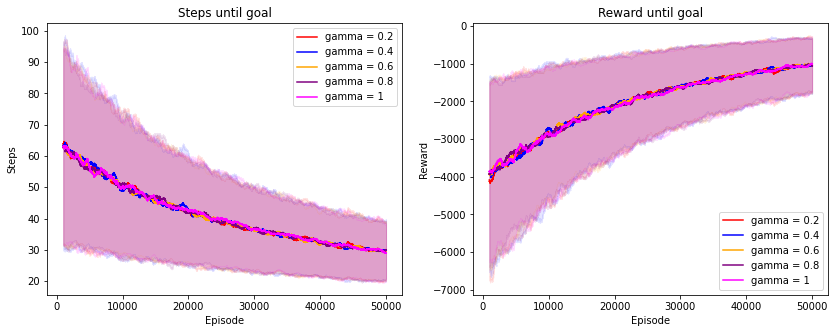

In [0]:
df = pd.read_csv("scores_training_gamma_0_4_.csv")
df2 = pd.read_csv("scores_training_gamma_0_5_.csv")
df3 = pd.read_csv("scores_training_gamma_0_6_.csv")
df4 = pd.read_csv("scores_training_gamma_0_7_.csv")
df5 = pd.read_csv("scores_training_gamma_0_8_.csv")

x = np.arange(0,len(df), 1)
fig, ax = plt.subplots(1,2, figsize =(14,5))
print(df.iloc[-1])
window = 1000
std_steps = df['Steps until goal'].rolling(window).std()
std_steps2 = df2['Steps until goal'].rolling(window).std()
std_steps3 = df3['Steps until goal'].rolling(window).std()
std_steps4 = df4['Steps until goal'].rolling(window).std()
std_steps5 = df5['Steps until goal'].rolling(window).std()

ax[0].plot(x, df['Steps until goal'].rolling(window).mean(), label = 'gamma = 0.2', color = 'red')
ax[0].fill_between(range(len(df['Steps until goal'])), df['Steps until goal'].rolling(window).mean() - std_steps, df['Steps until goal'].rolling(window).mean() + std_steps, color = 'red', alpha = 0.1)
ax[0].plot(x, df2['Steps until goal'].rolling(window).mean(), label = 'gamma = 0.4', color = 'blue')
ax[0].fill_between(range(len(df['Steps until goal'])), df2['Steps until goal'].rolling(window).mean() - std_steps2, df2['Steps until goal'].rolling(window).mean() + std_steps2, color = 'blue', alpha = 0.1)
ax[0].plot(x, df3['Steps until goal'].rolling(window).mean(), label = 'gamma = 0.6', color = 'orange')
ax[0].fill_between(range(len(df['Steps until goal'])), df3['Steps until goal'].rolling(window).mean() - std_steps3, df3['Steps until goal'].rolling(window).mean() + std_steps3, color = 'orange', alpha = 0.1)
ax[0].plot(x, df4['Steps until goal'].rolling(window).mean(), label = 'gamma = 0.8', color = 'purple')
ax[0].fill_between(range(len(df['Steps until goal'])), df4['Steps until goal'].rolling(window).mean() - std_steps4, df4['Steps until goal'].rolling(window).mean() + std_steps4, color = 'purple', alpha = 0.1)
ax[0].plot(x, df5['Steps until goal'].rolling(window).mean(), label = 'gamma = 1', color = 'magenta')
ax[0].fill_between(range(len(df['Steps until goal'])), df5['Steps until goal'].rolling(window).mean() - std_steps5, df5['Steps until goal'].rolling(window).mean() + std_steps5, color = 'magenta', alpha = 0.1)
ax[0].set_title("Steps until goal")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Steps")
ax[0].legend(loc = 'upper right')


std_reward = df['Reward_until_goal'].rolling(window).std()
std_reward2 = df2['Reward_until_goal'].rolling(window).std()
std_reward3 = df3['Reward_until_goal'].rolling(window).std()
std_reward4 = df4['Reward_until_goal'].rolling(window).std()
std_reward5 = df5['Reward_until_goal'].rolling(window).std()

ax[1].plot(x, df['Reward_until_goal'].rolling(window).mean(), label = 'gamma = 0.2', color = 'red')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df['Reward_until_goal'].rolling(window).mean() - std_reward, df['Reward_until_goal'].rolling(window).mean() + std_reward, color = 'red', alpha = 0.1)
ax[1].plot(x, df2['Reward_until_goal'].rolling(window).mean(), label = 'gamma = 0.4', color = 'blue')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df2['Reward_until_goal'].rolling(window).mean() - std_reward2, df2['Reward_until_goal'].rolling(window).mean() + std_reward2, color = 'blue', alpha = 0.1)
ax[1].plot(x, df3['Reward_until_goal'].rolling(window).mean(), label = 'gamma = 0.6', color = 'orange')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df3['Reward_until_goal'].rolling(window).mean() - std_reward3, df3['Reward_until_goal'].rolling(window).mean() + std_reward3, color = 'orange', alpha = 0.1)
ax[1].plot(x, df4['Reward_until_goal'].rolling(window).mean(), label = 'gamma = 0.8', color = 'purple')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df4['Reward_until_goal'].rolling(window).mean() - std_reward4, df4['Reward_until_goal'].rolling(window).mean() + std_reward4, color = 'purple', alpha = 0.1)
ax[1].plot(x, df5['Reward_until_goal'].rolling(window).mean(), label = 'gamma = 1', color = 'magenta')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df5['Reward_until_goal'].rolling(window).mean() - std_reward5, df5['Reward_until_goal'].rolling(window).mean() + std_reward5, color = 'magenta', alpha = 0.1)


ax[1].set_title("Reward until goal")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")
ax[1].legend(loc = 'lower right')
plt.show()

## let's try changing the alpha value

In [0]:
############### training #############
import time
start_time = time.time()
from IPython.display import clear_output
import random
import pandas as pd
import math

print( 20 * "#" + " Attention resetting Q matrix " + 20 * "#")
Q = np.zeros([env.observation_space.n, env.action_space.n])
print("Q matrix shape\n",Q.shape)

alpha = 0.1
gamma = 0.6

while alpha < 0.6:
  ##### epsilon values ####
  epsilon = 0.7  ############
  min_epsilon = 0.05 #######
  epsilon_decay = 1e-5 ####
  #########################
  # random amount of times during training where traffic is true
  threshold_traffic = 0.8
  ########################
  epochs = []
  average_rewards = []
  steps = []
  steps_until_goal = []
  reward_until_goal_list = []
  stop = False
  print("start state: ", env.start, "destination: ", env.goal)
  start_Q = np.zeros((2,4))
  for i in range(1,50_000): #We need to train very long to make sure we train for traffic and without traffic
    state = env.reset()
    #print("state", state)
    epochs, reward = 0,0
    step_until_goal = 0
    total_reward = 0
    reward_until_goal = 0
    done = False
    steps_traffic = 0
    steps_no_traffic = 0 
    while not done:
      ###### traffic on or off ########
      if random.uniform(0,1) > threshold_traffic: #make traffic true or false
        env.trafic_ON = True
        steps_traffic += 1
      else:
        env.trafic_ON = False
        steps_no_traffic += 1
      
      x,y = env.decode_state(env.state)[0], env.decode_state(env.state)[1]
      if env.trafic_ON:
        env.state = env.encode_state(x,y,x,y)
      if env.trafic_ON is False:
        env.state = env.encode_state(x,y,0,0)
      
      ######## epsilon greedy
      state = env.state
      if random.uniform(0,1) < epsilon: 
        action = env.action_space.sample() # explore 🧐
      else:
        action = np.argmax(Q[state]) # exploit 😈

      Prob, Next_state, Reward, Done = env.step(action)
      old_value = Q[state,action]
      next_max = np.max(Q[Next_state])
      old_state = state
      new_value = (1 - alpha)*old_value + alpha*(Reward + gamma + next_max)
      Q[state, action] = new_value
      
      ### metrics ####
      total_reward += Reward
      reward_until_goal += Reward
      state = Next_state
      env.state = state
      epochs += 1
      done = Done
      step_until_goal += 1

      
      #### append metrics to list ###
      if done:
        steps_until_goal.append(step_until_goal)
        reward_until_goal_list.append(reward_until_goal)

    
    ##### epsilon decay
    epsilon = max(min_epsilon, (epsilon*(1-epsilon_decay)))

    if i % 10000 == 0:
      print("Reward until destination: ", total_reward/epochs, "***steps until goal", step_until_goal)
      print("We have taken action '{}' and this resulted in state '{}' with a reward '{}'".format(action, Next_state, Reward))
      print("During this training '{}' of steps were with traffic and '{}' of steps were without traffic".format(steps_traffic, steps_no_traffic))
      average_rewards.append(total_reward/epochs)
      steps.append(step_until_goal)
    if i % 40000 == 0:
      print(20 * "#" + " We are training with Q learning  " + 20 * "#")

  steps_until_goal = np.array(steps_until_goal, dtype = 'float')
  reward_until_goal = np.array(reward_until_goal_list)
  print(steps_until_goal.shape)
  print(steps_until_goal)
  df = pd.DataFrame(steps_until_goal, columns = ['Steps until goal'] )
  df['Reward_until_goal'] = reward_until_goal
  df.to_csv("scores_training_alpha_0_" + str(int(alpha*10)) +"_.csv")
  print(10* "=" + "we saved the metrics" + 10* "=")
  print(20 * "#" + " We Finished training with Q learning " + 20 * "#")
  print(f'the final epsilon value after training is {epsilon}')
  print(f'trained with alpha{alpha}')
  alpha += 0.1
  alpha = round(alpha, 1)

#################### Attention resetting Q matrix ####################
Q matrix shape
 (10000, 4)
start state:  (8, 1, 0, 0) destination:  (1, 8, 0, 0)
Reward until destination:  -85.71698113207547 ***steps until goal 53
We have taken action '2' and this resulted in state '1818' with a reward '100'
During this training '13' of steps were with traffic and '40' of steps were without traffic
Reward until destination:  -31.36111111111111 ***steps until goal 36
We have taken action '2' and this resulted in state '1800' with a reward '100'
During this training '14' of steps were with traffic and '22' of steps were without traffic
Reward until destination:  -66.52222222222223 ***steps until goal 90
We have taken action '2' and this resulted in state '1818' with a reward '100'
During this training '20' of steps were with traffic and '70' of steps were without traffic
Reward until destination:  -27.73076923076923 ***steps until goal 26
We have taken action '2' and this resulted in state '1800' 

Unnamed: 0           49998.0
Steps until goal        32.0
Reward_until_goal     -940.0
Name: 49998, dtype: float64


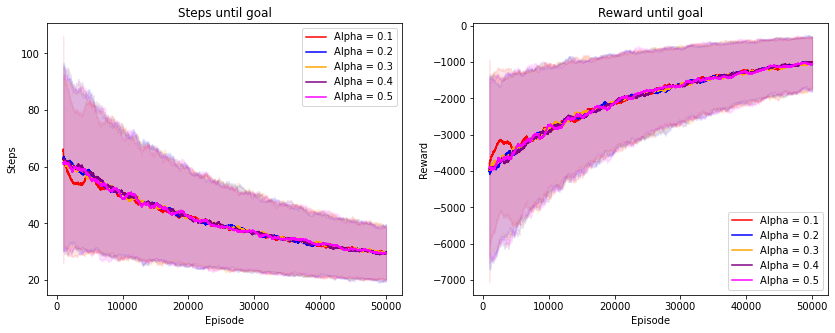

In [0]:
df = pd.read_csv("scores_training_alpha_0_1_.csv") 
df2 = pd.read_csv("scores_training_alpha_0_2_.csv")
df3 = pd.read_csv("scores_training_alpha_0_3_.csv")
df4 = pd.read_csv("scores_training_alpha_0_4_.csv")
df5 = pd.read_csv("scores_training_alpha_0_5_.csv")

x = np.arange(0,len(df), 1)
fig, ax = plt.subplots(1,2, figsize =(14,5))
print(df.iloc[-1])
window = 1000
std_steps = df['Steps until goal'].rolling(window).std()
std_steps2 = df2['Steps until goal'].rolling(window).std()
std_steps3 = df3['Steps until goal'].rolling(window).std()
std_steps4 = df4['Steps until goal'].rolling(window).std()
std_steps5 = df5['Steps until goal'].rolling(window).std()
ax[0].plot(x, df['Steps until goal'].rolling(window).mean(), label = 'Alpha = 0.1', color = 'red')
ax[0].fill_between(range(len(df['Steps until goal'])), df['Steps until goal'].rolling(window).mean() - std_steps, df['Steps until goal'].rolling(window).mean() + std_steps, color = 'red', alpha = 0.1)

ax[0].plot(x, df2['Steps until goal'].rolling(window).mean(), label = 'Alpha = 0.2', color = 'blue')
ax[0].fill_between(range(len(df['Steps until goal'])), df2['Steps until goal'].rolling(window).mean() - std_steps2, df2['Steps until goal'].rolling(window).mean() + std_steps2, color = 'blue', alpha = 0.1)

ax[0].plot(x, df3['Steps until goal'].rolling(window).mean(), label = 'Alpha = 0.3', color = 'orange')
ax[0].fill_between(range(len(df['Steps until goal'])), df3['Steps until goal'].rolling(window).mean() - std_steps3, df3['Steps until goal'].rolling(window).mean() + std_steps3, color = 'orange', alpha = 0.1)

ax[0].plot(x, df4['Steps until goal'].rolling(window).mean(), label = 'Alpha = 0.4', color = 'purple')
ax[0].fill_between(range(len(df['Steps until goal'])), df4['Steps until goal'].rolling(window).mean() - std_steps4, df4['Steps until goal'].rolling(window).mean() + std_steps4, color = 'purple', alpha = 0.1)

ax[0].plot(x, df5['Steps until goal'].rolling(window).mean(), label = 'Alpha = 0.5', color = 'magenta')
ax[0].fill_between(range(len(df['Steps until goal'])), df5['Steps until goal'].rolling(window).mean() - std_steps5, df5['Steps until goal'].rolling(window).mean() + std_steps5, color = 'magenta', alpha = 0.1)

ax[0].set_title("Steps until goal")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Steps")
ax[0].legend(loc = 'upper right')


std_reward = df['Reward_until_goal'].rolling(window).std()
std_reward2 = df2['Reward_until_goal'].rolling(window).std()
std_reward3 = df3['Reward_until_goal'].rolling(window).std()
std_reward4 = df4['Reward_until_goal'].rolling(window).std()
std_reward5 = df5['Reward_until_goal'].rolling(window).std()

ax[1].plot(x, df['Reward_until_goal'].rolling(window).mean(), label = 'Alpha = 0.1', color = 'red')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df['Reward_until_goal'].rolling(window).mean() - std_reward, df['Reward_until_goal'].rolling(window).mean() + std_reward, color = 'red', alpha = 0.1)

ax[1].plot(x, df2['Reward_until_goal'].rolling(window).mean(), label = 'Alpha = 0.2', color = 'blue')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df2['Reward_until_goal'].rolling(window).mean() - std_reward2, df2['Reward_until_goal'].rolling(window).mean() + std_reward2, color = 'blue', alpha = 0.1)

ax[1].plot(x, df3['Reward_until_goal'].rolling(window).mean(), label = 'Alpha = 0.3', color = 'orange')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df3['Reward_until_goal'].rolling(window).mean() - std_reward3, df3['Reward_until_goal'].rolling(window).mean() + std_reward3, color = 'orange', alpha = 0.1)

ax[1].plot(x, df4['Reward_until_goal'].rolling(window).mean(), label = 'Alpha = 0.4', color = 'purple')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df4['Reward_until_goal'].rolling(window).mean() - std_reward4, df4['Reward_until_goal'].rolling(window).mean() + std_reward4, color = 'purple', alpha = 0.1)

ax[1].plot(x, df5['Reward_until_goal'].rolling(window).mean(), label = 'Alpha = 0.5', color = 'magenta')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df5['Reward_until_goal'].rolling(window).mean() - std_reward5, df5['Reward_until_goal'].rolling(window).mean() + std_reward5, color = 'magenta', alpha = 0.1)


ax[1].set_title("Reward until goal")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")
ax[1].legend(loc = 'lower right')
plt.show()

## let's try some epsilon values

Unnamed: 0           49998.0
Steps until goal        14.0
Reward_until_goal       87.0
Name: 49998, dtype: float64


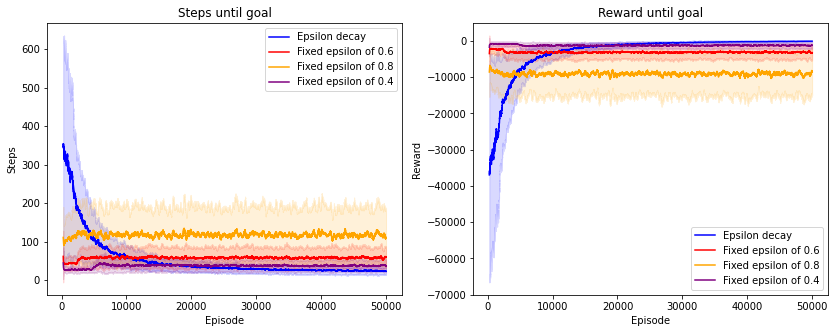

In [0]:
df = pd.read_csv("Scores_Maze/scores_during_training_Decay.csv") 
df2 = pd.read_csv("Scores_Maze/scores_during_training_fixed_epsilon.csv")
df3 = pd.read_csv("Scores_Maze/scores_during_training_fixed_epsilon_8.csv")
df4 = pd.read_csv("Scores_Maze/scores_during_training_fixed_epsilon_4.csv")
x = np.arange(0,len(df), 1)
fig, ax = plt.subplots(1,2, figsize =(14,5))
print(df.iloc[-1])
window = 250
std_steps = df['Steps until goal'].rolling(window).std()
std_steps2 = df2['Steps until goal'].rolling(window).std()
std_steps3 = df3['Steps until goal'].rolling(window).std()
std_steps4 = df4['Steps until goal'].rolling(window).std()
ax[0].plot(x, df['Steps until goal'].rolling(window).mean(), label = 'Epsilon decay', color = 'blue')
ax[0].fill_between(range(len(df['Steps until goal'])), df['Steps until goal'].rolling(window).mean() - std_steps, df['Steps until goal'].rolling(window).mean() + std_steps, color = 'blue', alpha = 0.15)

ax[0].plot(x, df2['Steps until goal'].rolling(window).mean(), label = 'Fixed epsilon of 0.6', color = 'red')
ax[0].fill_between(range(len(df['Steps until goal'])), df2['Steps until goal'].rolling(window).mean() - std_steps2, df2['Steps until goal'].rolling(window).mean() + std_steps2, color = 'red', alpha = 0.15)

ax[0].plot(x, df3['Steps until goal'].rolling(window).mean(), label = 'Fixed epsilon of 0.8', color = 'orange')
ax[0].fill_between(range(len(df['Steps until goal'])), df3['Steps until goal'].rolling(window).mean() - std_steps3, df3['Steps until goal'].rolling(window).mean() + std_steps3, color = 'orange', alpha = 0.15)

ax[0].plot(x, df4['Steps until goal'].rolling(window).mean(), label = 'Fixed epsilon of 0.4', color = 'purple')
ax[0].fill_between(range(len(df['Steps until goal'])), df4['Steps until goal'].rolling(window).mean() - std_steps4, df4['Steps until goal'].rolling(window).mean() + std_steps4, color = 'purple', alpha = 0.15)

ax[0].set_title("Steps until goal")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Steps")
ax[0].legend(loc = 'upper right')


std_reward = df['Reward_until_goal'].rolling(window).std()
std_reward2 = df2['Reward_until_goal'].rolling(window).std()
std_reward3 = df3['Reward_until_goal'].rolling(window).std()
std_reward4 = df4['Reward_until_goal'].rolling(window).std()
ax[1].plot(x, df['Reward_until_goal'].rolling(window).mean(), label = 'Epsilon decay', color = 'blue')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df['Reward_until_goal'].rolling(window).mean() - std_reward, df['Reward_until_goal'].rolling(window).mean() + std_reward, color = 'blue', alpha = 0.15)

ax[1].plot(x, df2['Reward_until_goal'].rolling(window).mean(), label = 'Fixed epsilon of 0.6', color = 'red')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df2['Reward_until_goal'].rolling(window).mean() - std_reward2, df2['Reward_until_goal'].rolling(window).mean() + std_reward2, color = 'red', alpha = 0.15)

ax[1].plot(x, df3['Reward_until_goal'].rolling(window).mean(), label = 'Fixed epsilon of 0.8', color = 'orange')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df3['Reward_until_goal'].rolling(window).mean() - std_reward3, df3['Reward_until_goal'].rolling(window).mean() + std_reward3, color = 'orange', alpha = 0.15)

ax[1].plot(x, df4['Reward_until_goal'].rolling(window).mean(), label = 'Fixed epsilon of 0.4', color = 'purple')
ax[1].fill_between(range(len(df['Reward_until_goal'])), df4['Reward_until_goal'].rolling(window).mean() - std_reward4, df4['Reward_until_goal'].rolling(window).mean() + std_reward4, color = 'purple', alpha = 0.15)

ax[1].set_title("Reward until goal")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Reward")
ax[1].legend(loc = 'lower right')
plt.show()

# The code below is used for building the R matrix for the report


 setting state to state at intersection with traffic true
state: 3333
[{0: [1, 2323, -15, False], 1: [1, 4343, -1, False], 2: [1, 3434, -1, False], 3: [1, 3232, -1, False]}]
[[ 2.323e+03 -1.500e+01]
 [ 4.343e+03 -1.000e+00]
 [ 3.434e+03 -1.000e+00]
 [ 3.232e+03 -1.000e+00]]
       State  Reward
North   2323     -15
South   4343      -1
East    3434      -1
West    3232      -1


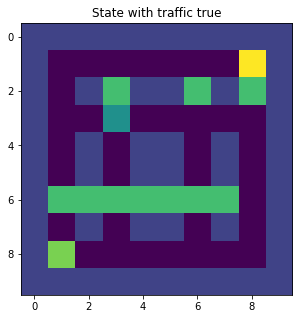

In [0]:
#we set a state at a intersection with traffic true
print("\n setting state to state at intersection with traffic true")
transitions_val = []
env.trafic_ON = True
intersect = block_width / blocks
intersect = int(intersect)
state = env.encode_state(intersect,intersect,intersect,intersect)
env.state = state
if env.start == env.state:
  print("we are in start position state:", env.state)
else:
  print("state:", env.state)
transitions_val.append(env.R[env.state])
#print("destination:",env.goal)
#print(env.R[36])
fig, ax = plt.subplots(figsize = (5,5))
img = env.render()
ax.imshow(img)
ax.set_title("State with traffic true")
env.trafic_ON = False
print(transitions_val)
R_array = np.zeros((4,2))
for i in range(4):
  R_array[i][0] = (transitions_val[0][i][1])
  R_array[i][1] = (transitions_val[0][i][2])
print(R_array)
import pandas as pd
df = pd.DataFrame(R_array, index = ['North', 'South', 'East', 'West'],columns = ['State', 'Reward'],dtype = 'int64' )
print(df)
df.to_csv("R_matrix_traffic.csv")

In [0]:
start_Q = np.zeros((2,4))
print("state", state)
start_Q[0] = Q[8100]
start_Q[1] = Q[8181]
print("start_Q", start_Q)
#df = pd.DataFrame(Q, columns = ['North', 'South', 'East', 'West'],dtype = 'int64' )
#print(df)
#df.to_csv("Q_matrix.csv")
df = pd.DataFrame(start_Q, index = ['State 8100', 'State 8181'],columns = ['North', 'South', 'East', 'West'],dtype = 'float32' )
df.to_csv("start_Q.csv")
print(df)

state 1800
start_Q [[  95.4 -104.4   95.4 -104.4]
 [  89.  -110.    89.8 -104.4]]
                North       South       East        West
State 8100  95.400002 -104.400002  95.400002 -104.400002
State 8181  89.000000 -110.000000  89.800003 -104.400002
